In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [3]:
df_result_accuracy = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'accuracy'])
df_result_rmse = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'rmse'])

In [4]:
geo = pd.read_csv('../datasets/healthcare.csv')
geo = geo.drop(columns=['Unnamed: 0'])
columns = ['A', 'C', 'H', 'D', 'I', 'O', 'T']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)
geo

,A,C,H,D,I,O,T
0,adult,none,none,0.0,60.951920,208.270608,392.597656
1,young,none,none,0.0,85.975117,69.108913,260.175850
2,young,none,none,0.0,90.088710,70.067062,274.118320
3,adult,none,none,0.0,139.532400,233.650271,512.696254
4,old,mild,none,0.0,84.896581,321.880259,556.283609
...,...,...,...,...,...,...,...
2995,young,none,none,0.0,60.833829,45.987380,225.318268
2996,adult,mild,none,0.0,67.750014,195.825954,388.724558
2997,old,mild,none,0.0,96.797948,430.435109,654.767639
2998,young,mild,none,0.0,12.815626,77.018709,212.537813


In [5]:
geo_train, geo_test = train_test_split(geo, test_size=0.1)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [6]:
geo_types = get_nodes_type(geo)
geo_types

{'A': 'disc',
 'C': 'disc',
 'H': 'disc',
 'D': 'cont',
 'I': 'cont',
 'O': 'cont',
 'T': 'cont'}

In [7]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [8]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


# Hill Climbing

# Дискретная структра + смешанные параметры

In [9]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_types)

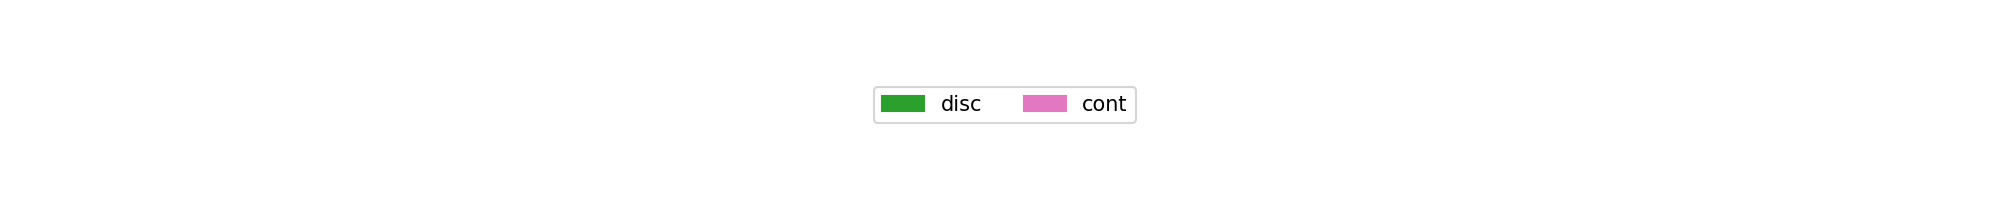

In [10]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [11]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [12]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [13]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

In [14]:
acc

{'A': 0.37, 'C': 0.75, 'H': 0.78}

In [15]:
rmse

{'D': 2.6, 'I': 1121.99, 'O': 110.76, 'T': 1158.74}

In [16]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [17]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_types)

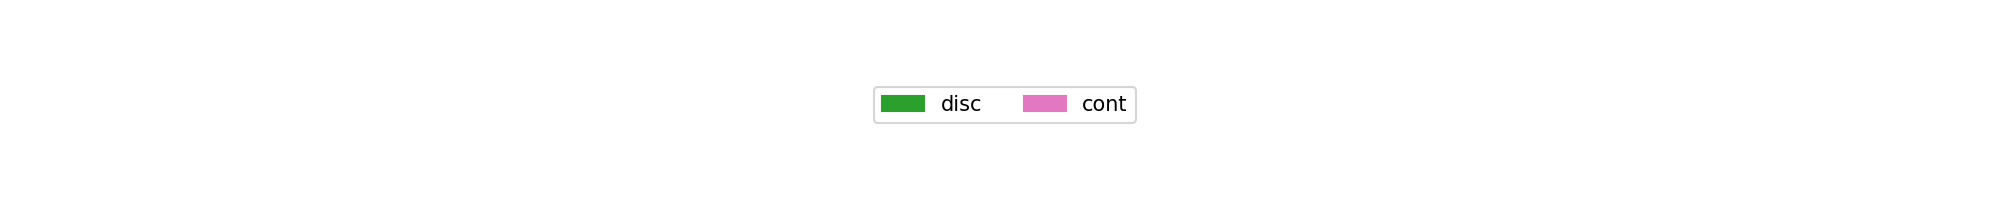

In [18]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [19]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [20]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [21]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

In [22]:
acc

{'A': 0.37, 'C': 0.75, 'H': 0.78}

In [23]:
rmse

{'D': 2.59, 'I': 1117.56, 'O': 110.73, 'T': 1161.32}

In [24]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная стурктура + дискретные параметры

In [25]:
geo_new_types = {'A': 'disc',
 'C': 'disc',
 'H': 'disc',
 'D': 'disc',
 'I': 'disc',
 'O': 'disc',
 'T': 'disc'}

In [26]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_new_types)

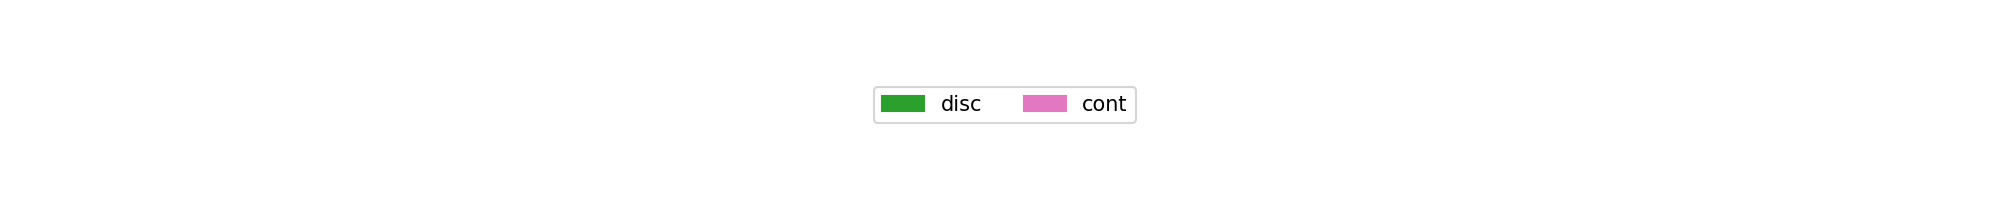

In [27]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [28]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [29]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [30]:
test_discrete = copy(geo_test)

In [31]:
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [32]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,A,C,H,D,I,O,T
0,old,none,any,1,4,4,4
1,old,none,any,1,4,4,4
2,adult,none,none,0,3,3,3
3,old,none,none,0,2,4,3
4,young,none,none,0,3,1,1
...,...,...,...,...,...,...,...
295,young,none,any,0,3,0,3
296,young,none,none,0,0,1,0
297,adult,severe,none,0,3,3,3
298,adult,severe,none,0,0,2,1


In [33]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [34]:
acc

{'A': 0.36, 'C': 0.75, 'H': 0.78, 'D': 0.0, 'I': 0.0, 'O': 0.0, 'T': 0.0}

In [35]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [36]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[3:7]), columns=['D', 'I', 'O', 'T']), ['D', 'I', 'O', 'T'], discrete_coder)

In [37]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[3:7]), columns=['D', 'I', 'O', 'T']), ['D', 'I', 'O', 'T'], discrete_coder)

In [38]:
m = mean_squared_error(invers_real['D'], invers_pred['D'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'D', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [39]:
m = mean_squared_error(invers_real['I'], invers_pred['I'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'I', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [40]:
m = mean_squared_error(invers_real['O'], invers_pred['O'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'O', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [41]:
m = mean_squared_error(invers_real['T'], invers_pred['T'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'T', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [42]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_new_types)

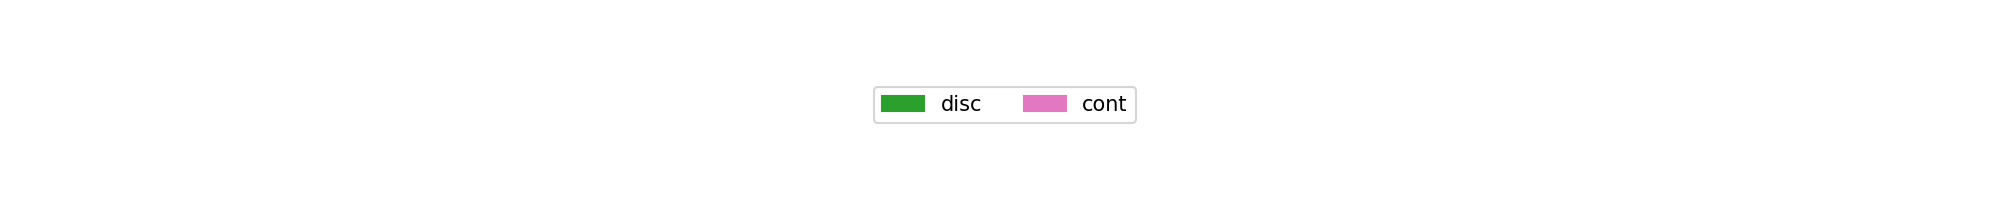

In [43]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [44]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [45]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [46]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [47]:
acc

{'A': 0.37, 'C': 0.75, 'H': 0.78, 'D': 0.0, 'I': 0.0, 'O': 0.0, 'T': 0.0}

In [48]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [49]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[3:7]), columns=['D', 'I', 'O', 'T']), ['D', 'I', 'O', 'T'], discrete_coder)

In [50]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[3:7]), columns=['D', 'I', 'O', 'T']), ['D', 'I', 'O', 'T'], discrete_coder)

In [51]:
m = mean_squared_error(invers_real['D'], invers_pred['D'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'D', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [52]:
m = mean_squared_error(invers_real['I'], invers_pred['I'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'I', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [53]:
m = mean_squared_error(invers_real['O'], invers_pred['O'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'O', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [54]:
m = mean_squared_error(invers_real['T'], invers_pred['T'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'T', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

# EVO

# Дискретная стурктура + смешанные параметры

In [55]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 5.9702
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 4.8734
Generation num: 1
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 4.485099999999999
Generation num: 2
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 4.485099999999999
Generation num: 3
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 3.8271
Generation num: 4
max_depth: 3, no improvements: 0
C

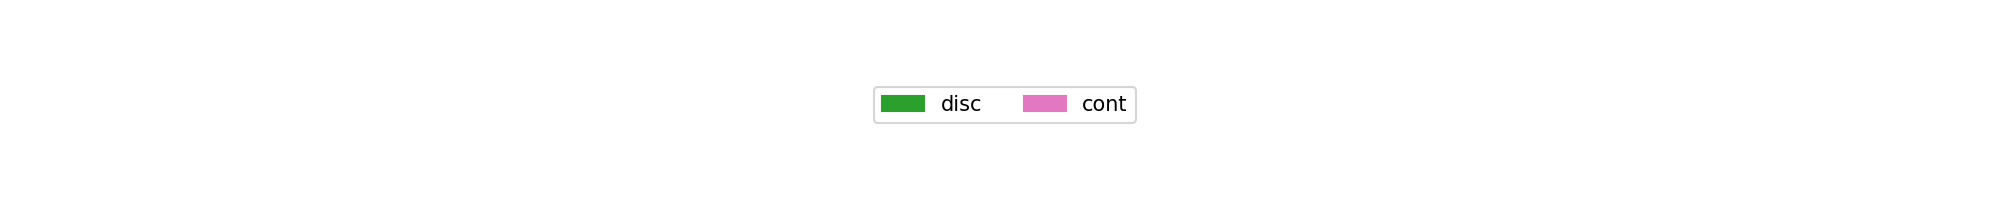

In [56]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [57]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [58]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [59]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

In [60]:
acc

{'A': 0.37, 'C': 0.75, 'H': 0.78}

In [61]:
rmse

{'D': 2.65, 'I': 1064.9, 'O': 42.13, 'T': 112.27}

In [62]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [63]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 19.347865810878393
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.3 min
Best metric is 15.432481475188522
Generation num: 1
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.5 min
Best metric is 15.432481475188522
Generation num: 2
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has 

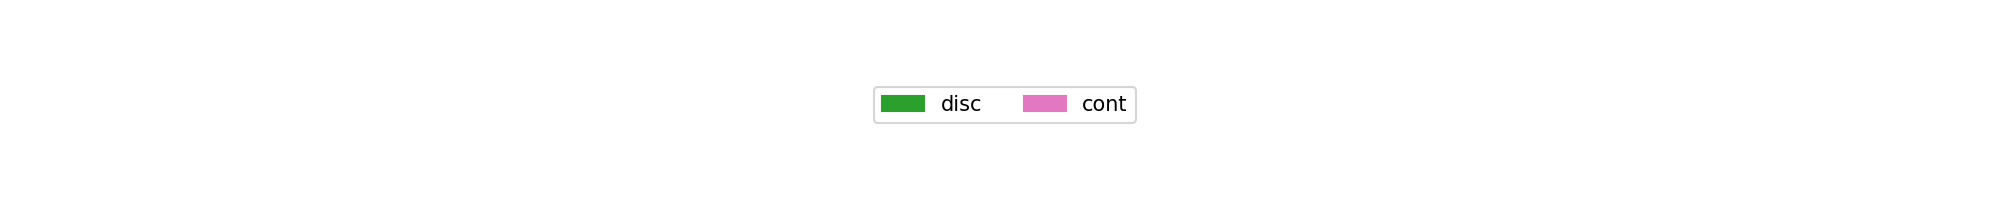

In [64]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [65]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [66]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [67]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

85


In [68]:
acc

{'A': 0.37, 'C': 0.75, 'H': 0.78}

In [69]:
rmse

{'D': 2.65, 'I': 10.18, 'O': 95.8, 'T': 426.22}

In [70]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная структура + дискретные параметры

In [71]:
geo_new_types = {'A': 'disc',
 'C': 'disc',
 'H': 'disc',
 'D': 'disc',
 'I': 'disc',
 'O': 'disc',
 'T': 'disc'}

In [72]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 5.310499999999999
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 5.310499999999999
Generation num: 1
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 4.4919
Generation num: 2
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 4.4919
Generation num: 3
max_depth: 3, no improvements: 1
Number of mutation attempts exceeded. Please check composer requirements 

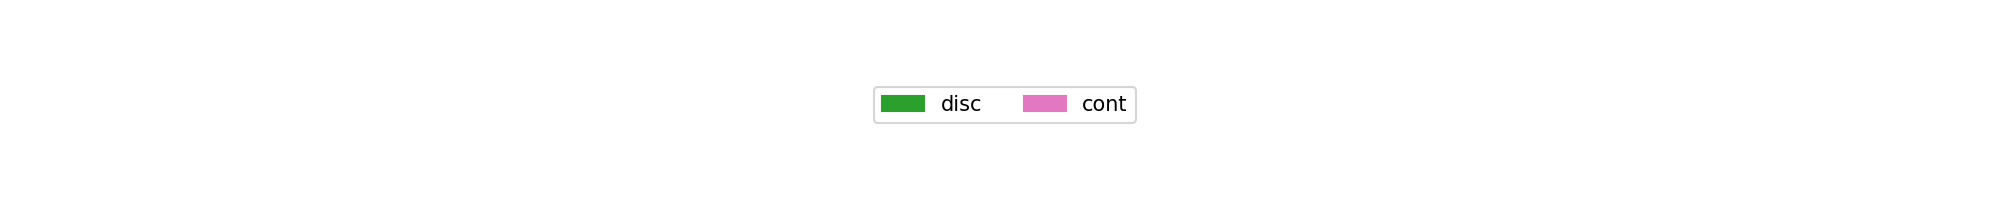

In [73]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [74]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [75]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [76]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [77]:
acc

{'A': 0.37, 'C': 0.75, 'H': 0.78, 'D': 0.0, 'I': 0.0, 'O': 0.0, 'T': 0.0}

In [78]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [79]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[3:7]), columns=['D', 'I', 'O', 'T']), ['D', 'I', 'O', 'T'], discrete_coder)

In [80]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[3:7]), columns=['D', 'I', 'O', 'T']), ['D', 'I', 'O', 'T'], discrete_coder)

In [81]:
m = mean_squared_error(invers_real['D'], invers_pred['D'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'D', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [82]:
m = mean_squared_error(invers_real['I'], invers_pred['I'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'I', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [83]:
m = mean_squared_error(invers_real['O'], invers_pred['O'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'O', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [84]:
m = mean_squared_error(invers_real['T'], invers_pred['T'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'T', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [85]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 19.415947236277223
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.4 min
Best metric is 19.347382737262997
Generation num: 1
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.5 min
Best metric is 19.347382737262997
Generation num: 2
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.6 min
Best metric is 19.347382737262997
Generation num: 3
max_depth: 3, no improvements: 2
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attr

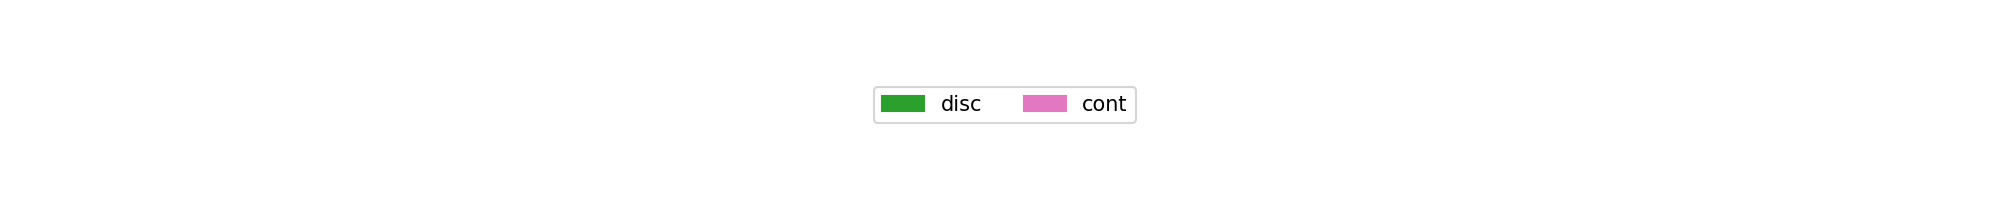

In [86]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [87]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [88]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [89]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [90]:
acc

{'A': 0.37, 'C': 0.75, 'H': 0.78, 'D': 0.0, 'I': 0.0, 'O': 0.0, 'T': 0.0}

In [91]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [92]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[3:7]), columns=['D', 'I', 'O', 'T']), ['D', 'I', 'O', 'T'], discrete_coder)

In [93]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[3:7]), columns=['D', 'I', 'O', 'T']), ['D', 'I', 'O', 'T'], discrete_coder)

In [94]:
m = mean_squared_error(invers_real['D'], invers_pred['D'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'D', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [95]:
m = mean_squared_error(invers_real['I'], invers_pred['I'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'I', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [96]:
m = mean_squared_error(invers_real['O'], invers_pred['O'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'O', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [97]:
m = mean_squared_error(invers_real['T'], invers_pred['T'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'T', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [98]:
df_result_accuracy.to_csv('health_results_disc.csv', index=False)
df_result_rmse.to_csv('health_results_cont.csv', index=False)